<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/FFN/DUDL_FFN_CodeChallenge_binMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

# The data

In [3]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

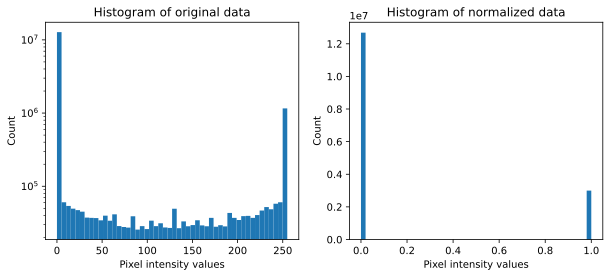

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [4]:
# Normalize the data to 0 or 1
data_norm = (data > 0).astype(float)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Confirm that the data have limited values
print(np.unique(data))
print('')
print(np.unique(data_norm))

# Create train/test groups using DataLoader

In [5]:
# Step 1: Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

# Step 2: Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Step 3: Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set = TensorDataset(test_data, test_labels)

# Step 4: Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [6]:
def create_the_MNIST_net():
    """"
    FFN_NONMNIST
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return torch.log_softmax(self.output(x), axis=1)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.NLLLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, loss_func, optimizer


In [7]:
# Test the model with one batch
net, loss_func, optimizer = create_the_MNIST_net()

X, y = iter(train_loader).next()
y_hat = net(X)

# Confirm really binary
torch.unique(X)

tensor([0., 1.])

# Create a function that trains the model

In [8]:
def train_the_model():
    """
    FFN_NONMNIST
    """
    
    num_epochs = 60

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_net()

    # Initialize
    losses    = torch.zeros(num_epochs)
    train_acc = []
    test_acc  = []

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(y_hat, axis=1) == y       # Booleans (True/False)
            matches_numeric = matches.float()                # Convert to numbers (1/0)
            accuracy_pct = 100 * torch.mean(matches_numeric) # Average and *100
            batch_acc.append(accuracy_pct)                   # Add to list of accuracies
        # End of batch loop.

        # Get the average training accuracy of the batches
        train_acc.append(np.mean(batch_acc))

        # The average losses accross the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        y_hat = net(X)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # End epochs

    return train_acc, test_acc, losses, net

# Run the model and show the results!

In [9]:
train_acc, test_acc, losses, net = train_the_model()

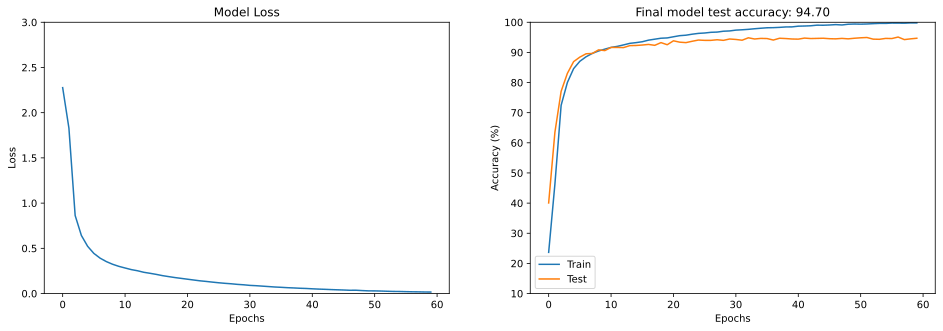

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc,  label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}')
ax[1].legend()

plt.show()

# Inspect the results in more detail

tensor([[2.7451e-06, 5.1450e-13, 4.8436e-10,  ..., 1.0488e-08, 1.8022e-06,
         9.9999e-01],
        [1.1291e-09, 3.9272e-13, 2.6654e-18,  ..., 1.7624e-17, 6.9766e-07,
         7.5044e-10],
        [1.7664e-15, 3.9446e-04, 9.9950e-01,  ..., 1.0138e-14, 1.6618e-08,
         1.0351e-18],
        ...,
        [9.5284e-11, 2.5533e-16, 3.4903e-20,  ..., 3.8847e-17, 6.9745e-08,
         1.8774e-09],
        [2.8278e-07, 1.5280e-06, 7.0398e-08,  ..., 1.9628e-07, 1.1808e-02,
         4.0033e-04],
        [1.1707e-12, 1.9498e-07, 1.0000e+00,  ..., 5.7210e-16, 1.3842e-08,
         4.5253e-18]])


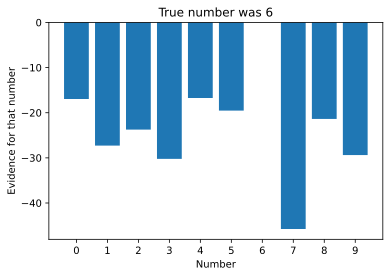

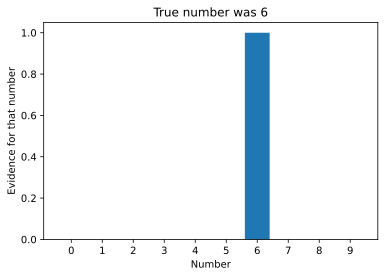

In [11]:
# Run the model through for the test data
X, y        = next(iter(test_loader))
predictions = net(X).detach()
print(torch.exp(predictions))

# Evidence for all numbers from one sample
sample_2_show = 120

plt.bar(range(10), predictions[sample_2_show])
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title(f'True number was {y[sample_2_show].item()}')
plt.show()

plt.bar(range(10), torch.exp(predictions[sample_2_show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title(f'True number was {y[sample_2_show].item()}')
plt.show()

[   5   17   18   80  125  131  132  135  201  207  210  223  234  255
  264  268  283  296  321  373  376  392  395  407  409  416  418  420
  424  475  480  482  502  523  561  569  584  593  607  614  615  637
  663  694  696  720  726  758  828  839  862  865  873  893  936 1067
 1080 1107 1132 1134 1137 1171 1180 1190 1217 1222 1231 1248 1273 1283
 1286 1299 1306 1320 1331 1344 1349 1433 1439 1444 1446 1488 1493 1504
 1507 1521 1526 1548 1551 1565 1613 1661 1757 1768 1774 1795 1857 1871
 1905 1906 1912 1939 1954 1968 1972 1979]


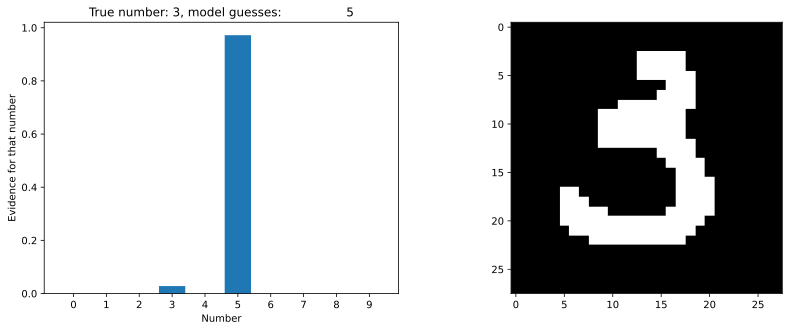

In [12]:
# Find the errors
errors = np.where(torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

# Evidence for all numbers from one sample
sample_2_show = 14

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample_2_show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title(f'True number: {y[errors[sample_2_show]].item()}, model guesses: \
                {torch.argmax(predictions[errors[sample_2_show]]).item()}')

ax[1].imshow( np.reshape(X[errors[sample_2_show],:],(28,28)), cmap='gray')

# Optional explorations
1) Invert the images so that the numbers are black against a white background. It seems intuitive that the
   model should perform just as well, but it's good to confirm. This is also a useful exercise to learn how
   to invert images, which will become useful when learning about augmenting image datasets.